<a href="https://colab.research.google.com/github/shyamjith94/TimeSeriesDataAnalysis/blob/main/KerasRNNTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [28]:
data = pd.read_csv("/content/drive/MyDrive/TimeSeriesDataAnalysis/Data/Alcohol_Sales.csv", index_col='DATE', parse_dates=True)

In [29]:
data.index.freq='MS'
data.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', length=325, freq='MS')

In [30]:
data.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [31]:
data.columns = ['Sales']

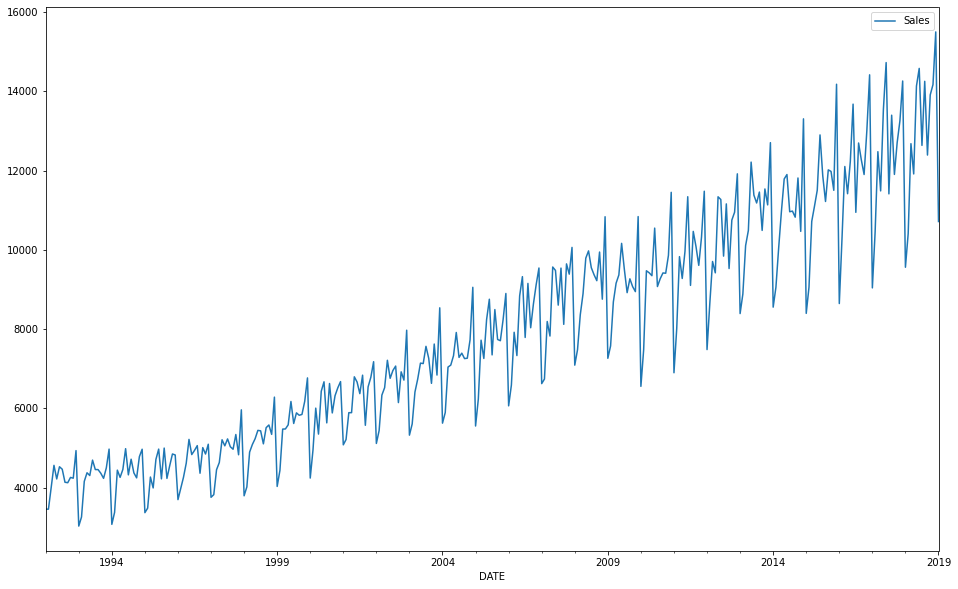

In [32]:
data.plot(figsize=(16,10))

Text(0, 0.5, 'resid')

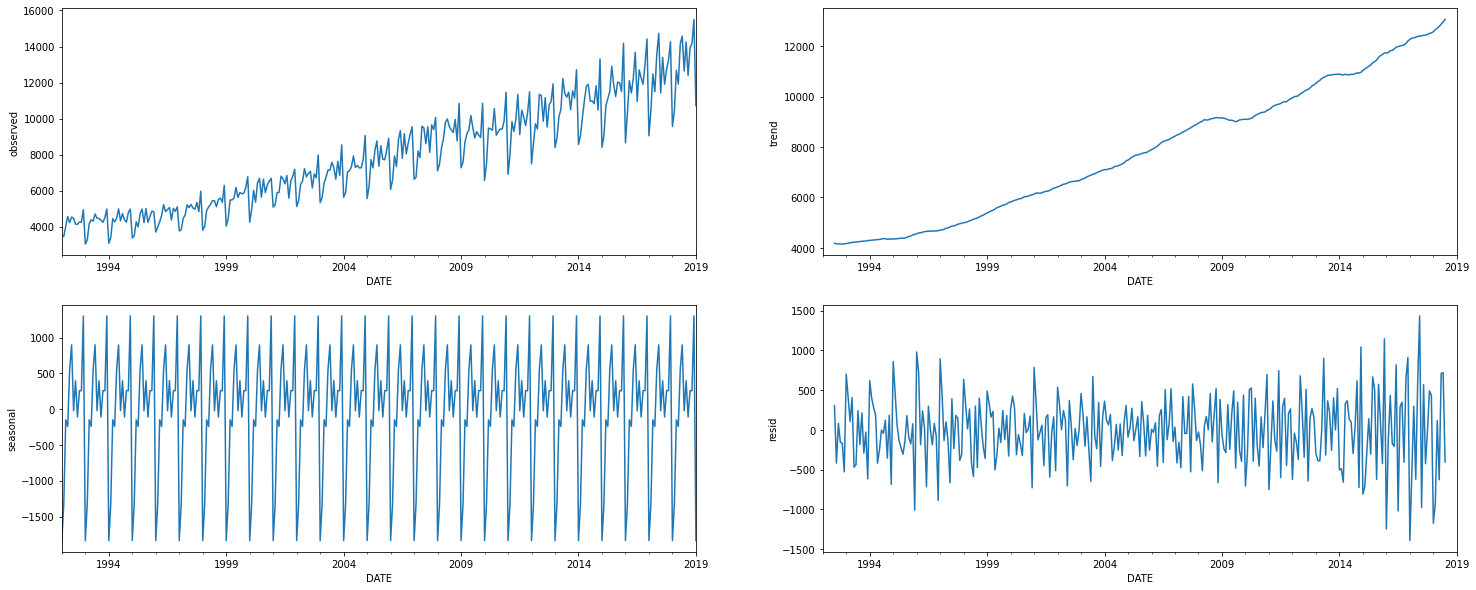

In [33]:
result = seasonal_decompose(data['Sales'])
fig, axe = plt.subplots(2,2,figsize=(25,10))

result.observed.plot(ax=axe[0,0])
axe[0,0].set_ylabel("observed")

result.trend.plot(ax=axe[0,1])
axe[0,1].set_ylabel("trend")

result.seasonal.plot(ax=axe[1,0])
axe[1,0].set_ylabel("seasonal")

result.resid.plot(ax=axe[1,1])
axe[1,1].set_ylabel("resid")

In [34]:
train_data = data.iloc[:313]
test_data = data.iloc[313:]
print(len(data) -12)
print(len(test_data))

313
12


**Normalize Data**

In [35]:
scaler = MinMaxScaler() # find max value devide to all data  use std also
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [23]:
# keras scaling use split out batches
n_input = 12
n_features = 1

# 313 - 2 = 311
# passing two times train data [v1, v2, v3] -> we predict v4 its available in train data 
train_generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
print("scaled_train_data len", len(scaled_train_data))
print("generator len", len(train_generator))

scaled_train_data len 313
generator len 301


In [24]:
print(scaled_train_data[:5])
print("\n")
x, y = train_generator[0]
print(x)

print("\n")
print(y)
# y value generating

[[0.03658432]
 [0.03649885]
 [0.08299855]
 [0.13103684]
 [0.1017181 ]]


[[[0.03658432]
  [0.03649885]
  [0.08299855]
  [0.13103684]
  [0.1017181 ]
  [0.12804513]
  [0.12266006]
  [0.09453799]
  [0.09359774]
  [0.10496624]
  [0.10334217]
  [0.16283443]]]


[[0.]]


**Model Creation**

In [25]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit_generator(train_generator, epochs=25)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0132
Epoch 2/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0098
Epoch 3/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0087
Epoch 4/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0064
Epoch 5/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0049
Epoch 6/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0038
Epoch 7/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0038
Epoch 8/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0027
Epoch 9/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0021
Epoch 10/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0024
Epoch 11/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0025
Epoch 12/25
301/301 [==========

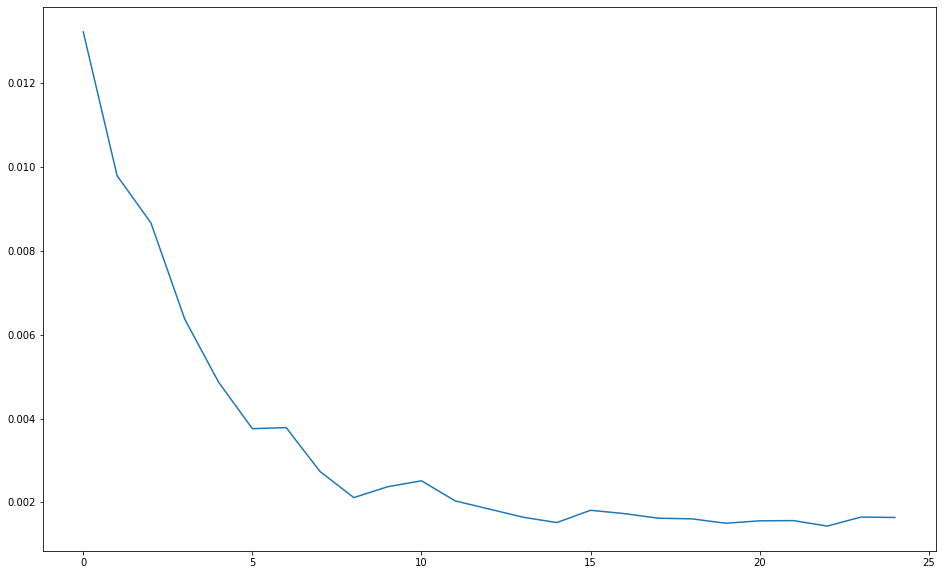

In [16]:
plt.figure(figsize=(16,10))
plt.plot(range(len(model.history.history['loss'])), model.history.history['loss'])

In [17]:
# 12 history steps(last 12 data) --> predict step 13
# last 12 point in train --> point 1 of test data

first_evaluation_batch = scaled_train_data[-12:] # last 12 point
first_evaluation_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [18]:
# change shape as network train data
first_evaluation_batch = first_evaluation_batch.reshape((1, n_input, n_features)) 

In [19]:
# predict first batch
model.predict(first_evaluation_batch)

array([[0.69929475]], dtype=float32)

**Forecasting**

In [20]:
test_prediction = []
first_evaluation_batch = scaled_train_data[-n_input:]
current_batch =  first_evaluation_batch.reshape((1, n_input, n_features)) 

for i in range(len(test_data)):
    current_pred = model.predict(current_batch)[0]
    test_prediction.append(current_pred)
    # update current batch, drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
print(scaled_test_data)
print("\n")
test_prediction

[[0.63116506]
 [0.82502778]
 [0.75972305]
 [0.94939738]
 [0.98743482]
 [0.82135225]
 [0.95956919]
 [0.80049577]
 [0.93025045]
 [0.95247457]
 [1.0661595 ]
 [0.65706471]]




[array([0.69929475], dtype=float32),
 array([0.82177055], dtype=float32),
 array([0.7689305], dtype=float32),
 array([0.92078894], dtype=float32),
 array([1.0039784], dtype=float32),
 array([0.7593915], dtype=float32),
 array([0.9071751], dtype=float32),
 array([0.77842575], dtype=float32),
 array([0.8494057], dtype=float32),
 array([0.8900004], dtype=float32),
 array([0.96898776], dtype=float32),
 array([0.61177695], dtype=float32)]

In [38]:
true_prediction = scaler.inverse_transform(test_prediction)
print(true_prediction)
print("\n")
test_data['true_prediction'] = true_prediction
print(test_data)

[[11212.04923254]
 [12644.89365065]
 [12026.71785849]
 [13803.30985314]
 [14776.54296958]
 [11915.12100226]
 [13644.04177207]
 [12137.80288571]
 [12968.19735366]
 [13443.11471385]
 [14367.18783849]
 [10188.17851436]]


            Sales  true_prediction
DATE                              
2018-02-01  10415     11212.049233
2018-03-01  12683     12644.893651
2018-04-01  11919     12026.717858
2018-05-01  14138     13803.309853
2018-06-01  14583     14776.542970
2018-07-01  12640     11915.121002
2018-08-01  14257     13644.041772
2018-09-01  12396     12137.802886
2018-10-01  13914     12968.197354
2018-11-01  14174     13443.114714
2018-12-01  15504     14367.187838
2019-01-01  10718     10188.178514


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


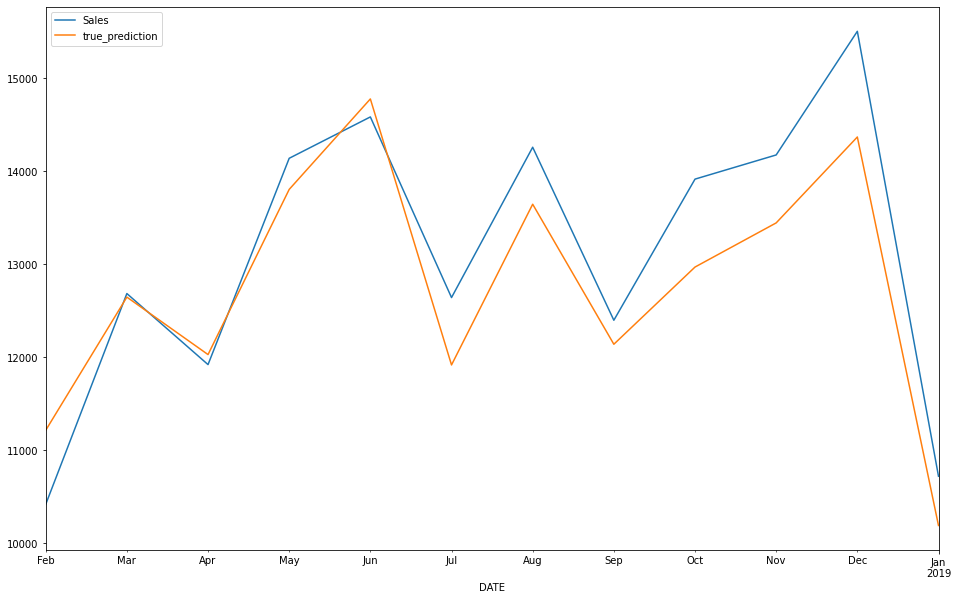

In [39]:
test_data.plot(figsize=(16,10), legend=True)

**Save Model**

In [42]:
model.save('/content/drive/MyDrive/TimeSeriesDataAnalysis/DeepLearning/KerasRNNTimeSeriesSavedModel.h5')

**Forecast unkmown future**

In [43]:
test_prediction = []
first_evaluation_batch = scaled_train_data[-n_input:]
current_batch =  first_evaluation_batch.reshape((1, n_input, n_features)) 

# exapand length loop
for i in range(50):
    current_pred = model.predict(current_batch)[0]
    test_prediction.append(current_pred)
    # update current batch, drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
print(scaled_test_data)
print("\n")
test_prediction

[[0.63116506]
 [0.82502778]
 [0.75972305]
 [0.94939738]
 [0.98743482]
 [0.82135225]
 [0.95956919]
 [0.80049577]
 [0.93025045]
 [0.95247457]
 [1.0661595 ]
 [0.65706471]]




[array([0.0296496], dtype=float32),
 array([0.02503396], dtype=float32),
 array([0.02041202], dtype=float32),
 array([0.01632355], dtype=float32),
 array([0.01279074], dtype=float32),
 array([0.00979415], dtype=float32),
 array([0.00742969], dtype=float32),
 array([0.00541742], dtype=float32),
 array([0.00384729], dtype=float32),
 array([0.00254733], dtype=float32),
 array([0.00147185], dtype=float32),
 array([0.00060787], dtype=float32),
 array([0.00021312], dtype=float32),
 array([0.00015623], dtype=float32),
 array([0.00011168], dtype=float32),
 array([7.8919824e-05], dtype=float32),
 array([5.4945744e-05], dtype=float32),
 array([3.7108603e-05], dtype=float32),
 array([2.4279805e-05], dtype=float32),
 array([1.526312e-05], dtype=float32),
 array([9.135199e-06], dtype=float32),
 array([5.147597e-06], dtype=float32),
 array([2.7776507e-06], dtype=float32),
 array([1.4934328e-06], dtype=float32),
 array([8.9347895e-07], dtype=float32),
 array([6.004109e-07], dtype=float32),
 array([3.

In [45]:
idx = pd.date_range('2018-02-01', periods=50, freq='MS')

In [54]:
true_prediction = scaler.inverse_transform(test_prediction)
pred = pd.DataFrame(data=true_prediction, index=idx, columns=['forcast'])
pred.index.freq = 'MS'
pred.index

DatetimeIndex(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01'],
              dtype='datetime64[ns]', freq='MS')

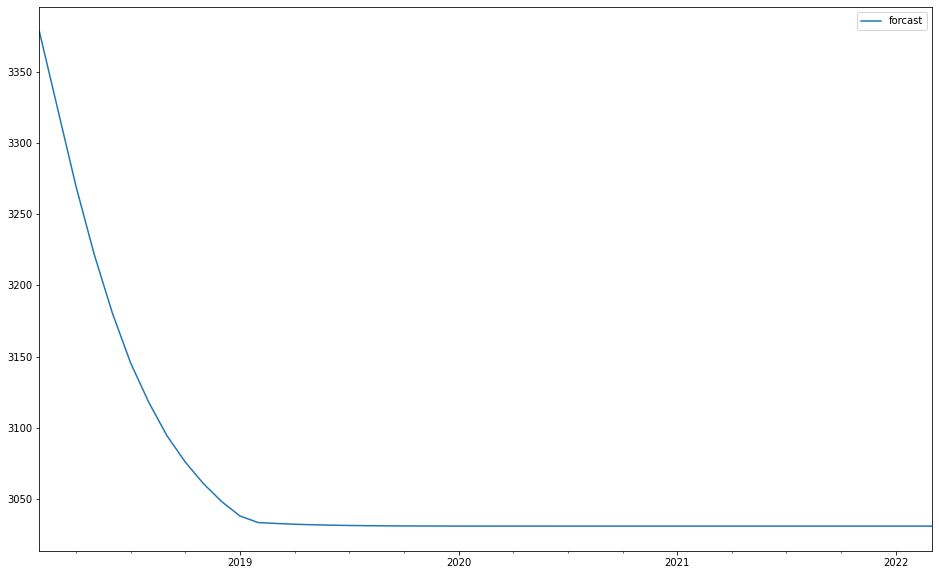

In [53]:
pred.plot(figsize=(16,10), legend=True)